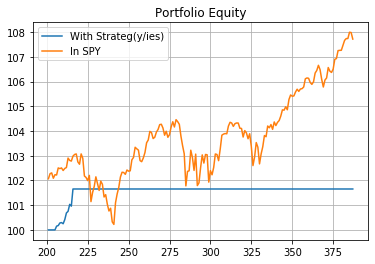

{'annual_return_rate': '1.65%',
 'maximum_drawdown': '-0.1%',
 'omega_ratio': '-',
 'sortino_ratio': -0.13}

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath("./strategizer"))
import datetime as datetime

from strategizer import DataFetcher, momentum_strategy, mean_reversion_strategy, Strategy, Portfolio, PerformanceReport

import pandas as pd
import matplotlib.pyplot as pyplot
%matplotlib inline

# work directory settings
TIME_SERIES_DATA_FILE_NAME = 'time_series.csv'
# test settings
test_settings = {
    "PERIOD_IN_DAYS": 565
}
# data provider
data_provider_settings = {
    "ALPHA_VANTAGE_API_URL": 'https://www.alphavantage.co/query?function=',
    "ALPHA_VANTAGE_FUNCTION": 'TIME_SERIES_DAILY_ADJUSTED',
    "ALPHA_VANTAGE_TIME_SERIES_LENGTH": 'full',
    "ALPHA_VANTAGE_API_KEY": os.environ.get('ALPHA_VANTAGE_API_KEY')
}
# portfolio settings
portfolio_settings = {
    "STARTING_CAPITAL": 100,
    "STOP_LOSS_RATE": 0.25,
    "MINIMAL_ACCEPTABLE_RETURN_RATE": 0.08,
    "STARTING_ANNUAL_RETURNS": []
}
strategies = [
    {
        "NAME": "momentum",
        "REWARD_GOAL_RATE": 0.08,
        "ASSET_SYMBOL": "MSFT",
        "CAPITAL_ALLOCATION_RATE": 0.2,
        "entry_criteria_handler": momentum_strategy.check_entry_criteria,
        "exit_criteria_handler": momentum_strategy.check_exit_criteria,
        "DATA_SOURCE": "alpha_vantage_api"
    },
    {
        "NAME": "mean_reversion",
        "REWARD_GOAL_RATE": 0.08,
        "ASSET_SYMBOL": "TSLA",
        "CAPITAL_ALLOCATION_RATE": 0.2,
        "entry_criteria_handler": mean_reversion_strategy.check_entry_criteria,
        "exit_criteria_handler": mean_reversion_strategy.check_exit_criteria,
        "DATA_SOURCE": "internal_web_scraping_service"
    }
]


def run_test(
    portfolio, 
    data_fetcher, 
    test_start_date, 
    test_end_date
):
    time_series_size = 0
    strategy_time_series = []
    
    for s in strategies: 
        time_series_data = data_fetcher.get_symbol_OHLC_data(
            data_provider_settings, 
            TIME_SERIES_DATA_FILE_NAME,
            s["ASSET_SYMBOL"],
            s["DATA_SOURCE"]
        )
        time_series_data_subset = data_fetcher.get_period_of_time_series(
            time_series_data, 
            test_start_date,
            test_end_date
        )
        strategy_time_series.append({
            "strategy_name": s["NAME"], 
            "time_series": time_series_data_subset
        })
        time_series_size = time_series_data_subset.shape[0]
        strategy = Strategy.Strategy(
            s["NAME"],
            s["entry_criteria_handler"], 
            s["exit_criteria_handler"],
            portfolio_settings["STOP_LOSS_RATE"],
            s["REWARD_GOAL_RATE"],
            s["ASSET_SYMBOL"],
            s["CAPITAL_ALLOCATION_RATE"]
        )
        portfolio.add_strategy(strategy)
    
    for d in range(time_series_size):
        positions_value = 0
        for s in range(len(strategies)):
            strategy = portfolio.strategies[s]
            strategy_specific_time_series = []
            for ssts in strategy_time_series:
                if ssts["strategy_name"] == strategies[s]["NAME"]:
                    strategy_specific_time_series = ssts["time_series"]
            if d > 200:
                value_to_add = 0
                reversed_time_series = strategy_specific_time_series.iloc[::-1]
                time_series_subset = reversed_time_series.head(d)
                portfolio.feed_time_series(
                    strategy.name,
                    time_series_subset, 
                    bool(d == time_series_data_subset.shape[0])
                )

                if strategy.has_entered_position and not strategy.position_exit_price:
                    value_to_add = strategy.position_order_size * time_series_subset.tail(1)["adjusted_close"].values[0]

                if strategy.position_exit_price:
                    value_to_add = 0
                
                positions_value += value_to_add
        if d > 200:
            portfolio.register_equity_for_day(
                d, 
                portfolio.available_capital + positions_value
            )
        
    return


def get_index_performance(
    data_fetcher, 
    index_symbol, 
    test_start_date, 
    test_end_date
):
    index_performance_data = {"x": [], "y": []}
    index_time_series = data_fetcher.get_symbol_OHLC_data(
        data_provider_settings, 
        TIME_SERIES_DATA_FILE_NAME,
        index_symbol,
        "alpha_vantage_api"
    )
    
    data_subset = data_fetcher.get_period_of_time_series(
        index_time_series,
        test_start_date,
        test_end_date
    )
    
    reversed_data_subset = data_subset.iloc[::-1]
    order_size = 0
    equity = portfolio_settings["STARTING_CAPITAL"]
    equity_after_position_purchase = 0
    total_capital_allocation_rate = 0
    for s in strategies:
        total_capital_allocation_rate += s["CAPITAL_ALLOCATION_RATE"]
    
    for d in range(reversed_data_subset.shape[0]):
        order_price = reversed_data_subset.head(d + 1)["adjusted_close"].values[d]
        
        if d == 0:
            order_size = (equity * total_capital_allocation_rate) / order_price
            order_cost = order_size * order_price
            commision = order_cost * 0.0
            total_order_cost = order_cost + commision
            equity_after_position_purchase = equity - total_order_cost
        
        if d > 1:
            equity = equity_after_position_purchase + (order_size * order_price)
        
        if d > 200:
            index_performance_data["x"].append(d)
            index_performance_data["y"].append(equity)
    
    return index_performance_data


def main():
    '''
    set up objects for the test
    '''
    portfolio = Portfolio.Portfolio(
        portfolio_settings["STARTING_CAPITAL"], 
        portfolio_settings["MINIMAL_ACCEPTABLE_RETURN_RATE"], 
        portfolio_settings["STARTING_ANNUAL_RETURNS"]
    )
    data_fetcher = DataFetcher.DataFetcher()
    test_end_date = datetime.date(2019, 12, 31) # datetime.date.today()
    test_start_date = test_end_date - datetime.timedelta(days=test_settings["PERIOD_IN_DAYS"])

    '''
    runs the test and populates the portfolio object with data
    necessary for the performance report generation
    '''
    run_test(portfolio, data_fetcher, test_start_date, test_end_date)
    
    '''
    show a report with risk/reward ratios and a return rate + plot performance against SPY
    '''
    performance_report = PerformanceReport.PerformanceReport()
    pyplot.figure()
    # capital returns if using this custom portfolio
    equity_curve_data = performance_report.get_portfolio_equity_curve(portfolio)
    pyplot.plot(
        equity_curve_data["x"], 
        equity_curve_data["y"],
        label = "With Strateg(y/ies)"
    )
    # capital returns if placed in s&p500
    s_and_p_performance_data = get_index_performance(
        data_fetcher, 
        "SPY",
        test_end_date - datetime.timedelta(days=test_settings["PERIOD_IN_DAYS"]),
        test_end_date
    )
    pyplot.plot(
        s_and_p_performance_data["x"], 
        s_and_p_performance_data["y"],
        label = "In SPY"
    )
    pyplot.title('Portfolio Equity')
    pyplot.grid(True)
    pyplot.legend()
    pyplot.show()
    return performance_report.generate_report(portfolio)


main()